In [55]:
from datetime import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
import cmasher as cmr
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
from metpy.units import units
import numpy as np
from scipy.ndimage import gaussian_filter
import xarray as xr

In [56]:
ds = xr.open_dataset('SRH_Pressure.nc')
ds

<xarray.Dataset>
Dimensions:    (longitude: 33, latitude: 29, level: 18, time: 2)
Coordinates:
  * longitude  (longitude) float32 117.0 117.2 117.5 117.8 ... 124.5 124.8 125.0
  * latitude   (latitude) float32 20.0 19.75 19.5 19.25 ... 13.5 13.25 13.0
  * level      (level) int32 400 450 500 550 600 650 ... 900 925 950 975 1000
  * time       (time) datetime64[ns] 2016-08-14T06:00:00 2016-08-14T08:00:00
Data variables:
    u          (time, level, latitude, longitude) float32 ...
    v          (time, level, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-06-13 08:09:36 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [57]:
ds1 = xr.open_dataset('SRH_Surf.nc')
ds1

<xarray.Dataset>
Dimensions:    (longitude: 33, latitude: 29, time: 2)
Coordinates:
  * longitude  (longitude) float32 117.0 117.2 117.5 117.8 ... 124.5 124.8 125.0
  * latitude   (latitude) float32 20.0 19.75 19.5 19.25 ... 13.5 13.25 13.0
  * time       (time) datetime64[ns] 2016-08-14T06:00:00 2016-08-14T08:00:00
Data variables:
    u10        (time, latitude, longitude) float32 ...
    v10        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-06-13 08:07:18 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [58]:
# Grab lat/lon values (NAM will be 2D)
lats = ds['latitude']
lons = ds['longitude']

pressure = ds.level * units('hPa')
heights = mpcalc.pressure_to_height_std(pressure) # For reference heights

# Include the wind components

uwind = ds['u'] # U-component of Wind Isobaric
vwind = ds['v'] # V-component of Wind Isobaric
usurf = ds1['u10'] # Surface U-component winds
vsurf = ds1['v10'] # Surface V-component winds

# Select all the parameters in various pressure from surface to 700 hPa

# u-component of Wind

uwnd_surf10 = gaussian_filter(usurf.data[1], sigma=1) * units('m/s')
uwnd_1000 = gaussian_filter(uwind.sel(level=1000).data[1], sigma=1) * units('m/s')
uwnd_975 = gaussian_filter(uwind.sel(level=950).data[1], sigma=1) * units('m/s')
uwnd_950 = gaussian_filter(uwind.sel(level=950).data[1], sigma=1) * units('m/s')
uwnd_925 = gaussian_filter(uwind.sel(level=925).data[1], sigma=1) * units('m/s')
uwnd_900 = gaussian_filter(uwind.sel(level=900).data[1], sigma=1) * units('m/s')
uwnd_875 = gaussian_filter(uwind.sel(level=875).data[1], sigma=1) * units('m/s')
uwnd_850 = gaussian_filter(uwind.sel(level=850).data[1], sigma=1) * units('m/s')
uwnd_825 = gaussian_filter(uwind.sel(level=825).data[1], sigma=1) * units('m/s')
uwnd_800 = gaussian_filter(uwind.sel(level=800).data[1], sigma=1) * units('m/s')
uwnd_775 = gaussian_filter(uwind.sel(level=775).data[1], sigma=1) * units('m/s')
uwnd_750 = gaussian_filter(uwind.sel(level=750).data[1], sigma=1) * units('m/s')
uwnd_700 = gaussian_filter(uwind.sel(level=700).data[1], sigma=1) * units('m/s')

# v-component of Wind

vwnd_surf10 = gaussian_filter(vsurf.data[1], sigma=1) * units('m/s')
vwnd_1000 = gaussian_filter(vwind.sel(level=1000).data[1], sigma=1) * units('m/s')
vwnd_975 = gaussian_filter(vwind.sel(level=950).data[1], sigma=1) * units('m/s')
vwnd_950 = gaussian_filter(vwind.sel(level=950).data[1], sigma=1) * units('m/s')
vwnd_925 = gaussian_filter(vwind.sel(level=925).data[1], sigma=1) * units('m/s')
vwnd_900 = gaussian_filter(vwind.sel(level=900).data[1], sigma=1) * units('m/s')
vwnd_875 = gaussian_filter(vwind.sel(level=875).data[1], sigma=1) * units('m/s')
vwnd_850 = gaussian_filter(vwind.sel(level=850).data[1], sigma=1) * units('m/s')
vwnd_825 = gaussian_filter(vwind.sel(level=825).data[1], sigma=1) * units('m/s')
vwnd_800 = gaussian_filter(vwind.sel(level=800).data[1], sigma=1) * units('m/s')
vwnd_775 = gaussian_filter(vwind.sel(level=775).data[1], sigma=1) * units('m/s')
vwnd_750 = gaussian_filter(vwind.sel(level=750).data[1], sigma=1) * units('m/s')
vwnd_700 = gaussian_filter(vwind.sel(level=700).data[1], sigma=1) * units('m/s')

tot_uwind = uwnd_surf10 + uwnd_1000 + uwnd_975 + uwnd_950 + uwnd_925 + uwnd_900 + uwnd_875 + uwnd_850 + uwnd_825 + uwnd_800 + uwnd_775 + uwnd_750 + uwnd_700
mean_uwind = tot_uwind / 13

tot_vwind = vwnd_surf10 + vwnd_1000 + vwnd_975 + vwnd_950 + vwnd_925 + vwnd_900 + vwnd_875 + vwnd_850 + vwnd_825 + vwnd_800 + vwnd_775 + vwnd_750 + vwnd_700
mean_vwind = tot_vwind / 13

del_uwind = uwnd_700 - uwnd_surf10
del_vwind = vwnd_700 - vwnd_surf10

z = 3000 * units('m') # For Streamwise Helicity
z1 = 500 * units('m') # For Streamwise Vorticity

swv_u = uwnd_950 - uwnd_surf10 # 0-500 m SW Vorticity
swv = swv_u / z1

term_1 = mean_vwind * del_uwind / z
term_2 = mean_uwind * del_vwind / z

h = term_1 - term_2 # 0-3 km SW Helicity

vtime = datetime.strptime(str(ds.time.data[1].astype('datetime64[ms]')),
                          '%Y-%m-%dT%H:%M:%S.%f')

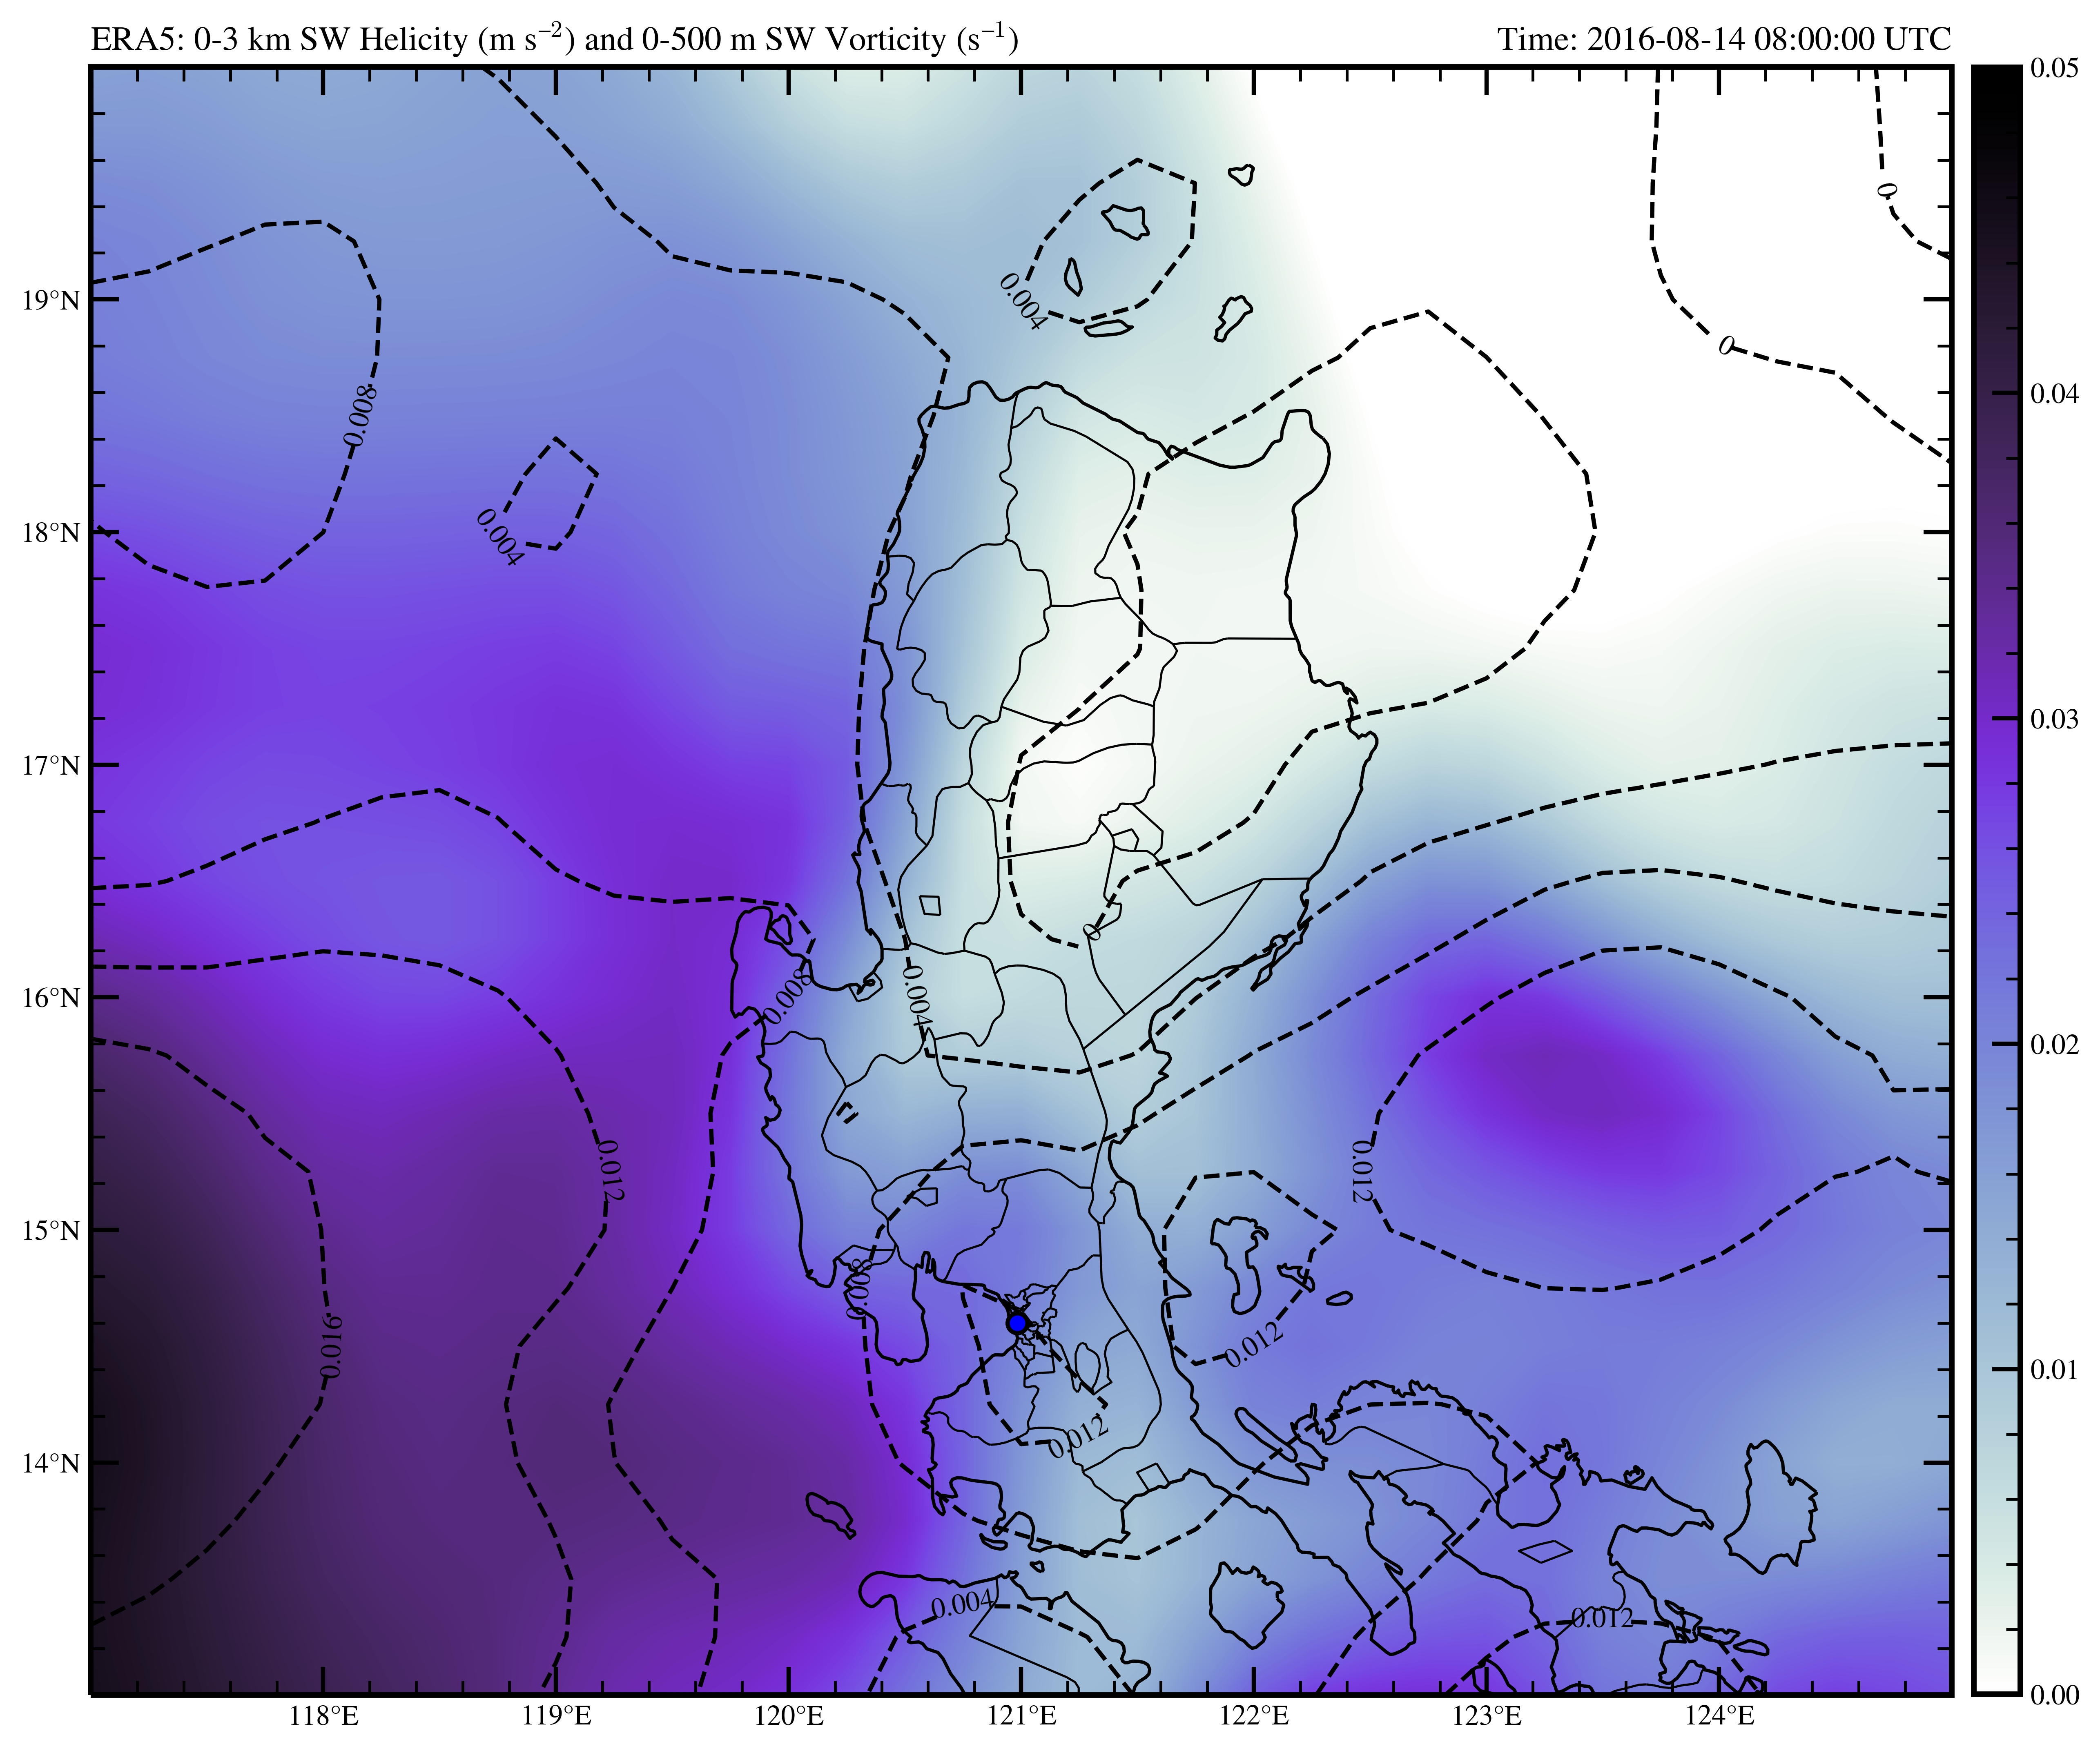

In [54]:
# Set up the projection that will be used for plotting
mapcrs = ccrs.PlateCarree()

# Set up the projection of the data; if lat/lon then PlateCarree is what you want
datacrs = ccrs.PlateCarree()

# Start the figure and create plot axes with proper projection
fig = plt.figure(1, figsize=(14, 12))
ax = plt.subplot(111, projection=datacrs)
ax.set_extent([117, 125, 13, 20], ccrs.PlateCarree())

# Add geopolitical boundaries for map reference
states_provinces = cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lines', 
                                                scale='10m', facecolor='none', linewidth=0.75)
ax.add_feature(states_provinces, edgecolor='k')
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=1.15)
ax.add_feature(cfeature.STATES.with_scale('50m'))

# Add Streamwise Vorticty contour lines
swv_range = np.arange(0, 0.024, 0.004)
swv_cf = ax.contour(lons, lats, swv, swv_range, colors='k', linestyles="--", transform=datacrs)
ax.clabel(swv_cf, fmt='%3g')

# Access rainforest colormap through CMasher or MPL
cmap = cmr.rainforest
cmap = plt.get_cmap('cmr.amethyst_r') 

# Plot colorfill Streamwise Helicity
h_lim = np.arange(0, 0.0501, 0.0001)
cf = ax.contourf(lons, lats, h, h_lim, cmap=cmap, transform=datacrs)
cbar = plt.colorbar(cf, orientation='vertical', pad=0.01, aspect=35, shrink=0.664,
                    ticks = [0, 0.01, 0.02, 0.03, 0.04, 0.05])
cbar.ax.minorticks_on()
cbar.ax.tick_params(which='major', length=10, width=1.5, top=True, right=True, direction='in')
cbar.ax.tick_params(which='minor', length=5, width=1, top=True, right=True, direction='in')

# Make some nice titles for the plot (one right, one left)
ax.set_title('ERA5: 0-3 km SW Helicity (m s$^{–2}$) and 0-500 m SW Vorticity (s$^{–1}$)', loc='left')
ax.set_title('Time: {} UTC'.format(vtime), loc='right')

# Add marker of Manila, NCR via its lats and lons
manila_lon, manila_lat = 120.9842, 14.5995
ax.plot(manila_lon, manila_lat, color='blue', markersize=7, 
        markeredgewidth=1.5, markeredgecolor='k', marker='o', transform=datacrs)

# Set X and Y-ticks for Latitude and Longitude Coordinates
ax.set_yticks(lats, 5, crs=ccrs.PlateCarree())
ax.set_xticks(lons, 5, crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
long_formatter = cticker.LongitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)
ax.xaxis.set_major_formatter(long_formatter)
ax.set_xticks(ax.get_xticks()[1:8]) #Hide end points of longitude tickmarks
ax.set_yticks(ax.get_yticks()[1:7]) #Hide end points of latitude tickmarks
ax.minorticks_on()
ax.tick_params(which='major', length=10, width=1.5, top=True, right=True, direction='in')
ax.tick_params(which='minor', length=5, width=1, top=True, right=True, direction='in')

# Adjust image and show
plt.subplots_adjust(bottom=0, top=1)
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['figure.dpi'] = 500
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.savefig('Helicity and Vorticity.jpg', bbox_inches="tight")
plt.show()